In [17]:
from fastai.vision.widgets import * 
import ipywidgets as widgets
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
def getStockData(stCode):
    msft = yf.Ticker(stCode)
    # get historical market data
    cdsl = msft.history(period="max")
    cdsl = cdsl.reset_index(level=0)

    return cdsl;


In [19]:
def plotThestocks(data):
    #seaborn.set_style:{darkgrid, whitegrid, dark, white, ticks}
    sns.set_style("darkgrid")
    plt.figure(figsize = (15,9))
    plt.plot(data[['Close']])
    plt.xticks(range(0,data.shape[0],250),data['Date'].loc[::250],rotation=45)
    plt.title("Google Stock Price",fontsize=18, fontweight='bold')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price (USD)',fontsize=18)
    plt.show()

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
def normalizeData(data):
    price = data[['Close']]
#     price.info()
    
    price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
    
    return price;

In [21]:
import torch
import torch.nn as nn
import numpy as np

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
    y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


    return [x_train, y_train_gru, x_test, y_test_gru]

In [22]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [39]:
def trainModelGRU(input_dim, hidden_dim, output_dim, num_layers, num_epochs
                  , x_train, y_train_gru):
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    hist = np.zeros(num_epochs)
    start_time = time.time()
    gru = []
    
    for t in range(num_epochs):
        y_train_pred = model(x_train)
    
        loss = criterion(y_train_pred, y_train_gru)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    training_time = time.time()-start_time    
    print("Training time: {}".format(training_time))
    
    predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
    original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

    return [predict, original, y_train_pred, model]


In [40]:
import seaborn as sns

def plotPredictions(original, predict):
    sns.set_style("darkgrid")    
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)
    
    
    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

In [56]:
import math, time
from sklearn.metrics import mean_squared_error




def invertPrediction(y_train_pred, y_train_gru, y_test_gru, x_test, model):
    # make predictions
    y_test_pred = model(x_test)
    
    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test = scaler.inverse_transform(y_test_gru.detach().numpy())
    
    return [y_train_pred, y_train, y_test_pred, y_test]

In [57]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

NameError: name 'y_train' is not defined

In [61]:
import plotly.express as px
import plotly.graph_objects as go

def plotPredictions(y_train_pred, y_test_pred, price, lookback):
    #shift train predictions for plotting
    trainPredictPlot = np.empty_like(price)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred
    
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(price)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred
    
    original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))
    
    predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)

    fig = go.Figure()
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                        mode='lines',
                        name='Train prediction')))
    fig.add_trace(go.Scatter(x=result.index, y=result[1],
                        mode='lines',
                        name='Test prediction'))
    fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                        mode='lines',
                        name='Actual Value')))
    fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=True,
            showticklabels=False,
            linecolor='white',
            linewidth=2
        ),
        yaxis=dict(
            title_text='Close (USD)',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='white',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='white',
            ),
        ),
        showlegend=True,
        template = 'plotly_dark'
    
    )
    
    
    
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text='Results (GRU)',
                                  font=dict(family='Rockwell',
                                            size=26,
                                            color='white'),
                                  showarrow=False))
    fig.update_layout(annotations=annotations)
    
    fig.show()

In [64]:
def on_button_clicked(b):
    
    lookback = 20 # choose sequence length
    input_dim  = 1
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    num_epochs = 100
    
    
    
    value_list.append(inp.value)
    stCode = value_list[0]
#     stCode = inp.vale
    print(stCode)
    data = getStockData(stCode)
#     data['Date'] = data.index
    del data['Dividends']
    del data['Stock Splits']
    
    print(data.shape)
    plotThestocks(data)
    
    price = normalizeData(data)
    
    
    x_train, y_train_gru, x_test, y_test = split_data(price, lookback)

    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train_gru.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
    
    predict_train, original_train, y_train_pred, model = trainModelGRU(input_dim, hidden_dim, output_dim, num_layers, num_epochs, x_train, y_train_gru)
#     plotPredictions(original, predict)
    
    
    y_train_pred, y_train, y_test_pred, y_test = invertPrediction(y_train_pred, y_train_gru, y_test, x_test, model)

#     def invertPrediction(y_train_pred, y_train_gru, y_test_pred, y_test_gru):
        
    plotPredictions(y_train_pred, y_test_pred, price, lookback)
#     print(data.head())
    

GOOGL
(4543, 6)


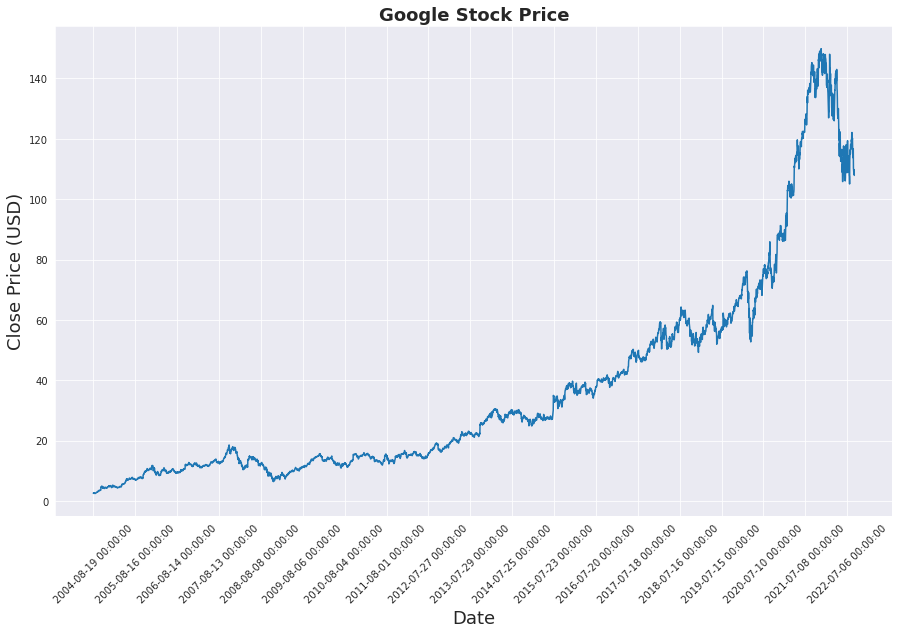

/tmp/ipykernel_4725/4091281541.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



x_train.shape =  torch.Size([3618, 19, 1])
y_train.shape =  torch.Size([3618, 1])
x_test.shape =  torch.Size([905, 19, 1])
y_test.shape =  torch.Size([905, 1])
Epoch  0 MSE:  0.6735897660255432
Epoch  1 MSE:  0.2880587875843048
Epoch  2 MSE:  0.05241214483976364
Epoch  3 MSE:  0.13588739931583405
Epoch  4 MSE:  0.11459822952747345
Epoch  5 MSE:  0.03743668645620346
Epoch  6 MSE:  0.034838467836380005
Epoch  7 MSE:  0.062341250479221344
Epoch  8 MSE:  0.07544230669736862
Epoch  9 MSE:  0.06779058277606964
Epoch  10 MSE:  0.04933425784111023
Epoch  11 MSE:  0.032283440232276917
Epoch  12 MSE:  0.02561117894947529
Epoch  13 MSE:  0.030817488208413124
Epoch  14 MSE:  0.0398835763335228
Epoch  15 MSE:  0.04254428669810295
Epoch  16 MSE:  0.036843787878751755
Epoch  17 MSE:  0.028339790180325508
Epoch  18 MSE:  0.022801626473665237
Epoch  19 MSE:  0.02200055681169033
Epoch  20 MSE:  0.024262651801109314
Epoch  21 MSE:  0.0268081184476614
Epoch  22 MSE:  0.027544932439923286
Epoch  23 MSE:  0

In [66]:

button = widgets.Button(description="Enter")
inp = widgets.Text(description='Stock Code:')
Box = widgets.HBox([inp, button])

value_list = []


    
#     print(value_list)
#     print(b)

button.on_click(on_button_clicked)
Box